In [1]:
root_folder='/media/DATA/jbonato/astro_segm'

# Training Phase Pre-Processing
In this notebook there is a guide for the pre-processing step in the trainig phase.
### Information
The role of the functions in the code is described briefly in code comments 


In [2]:
import numpy as np
import os
from skimage import io
import sys
import h5py
import glob
from skimage import io
import matplotlib.pyplot as plt
import pickle

#### MODULES used in the code
sys.path.insert(0,root_folder+'/RASTA/modules/')
#from img_Sp_Sharp import create_img
from mask_roi_from_fiji import create_mask
from gen_single_astro import save_im, spatial_pp

#SET IMAGES DIM
N = 512
M = 512 



In [3]:
set_dir = root_folder+'/set4/'
folder_to_save = root_folder+'/set4/dataset/'
folder_single = root_folder+'/set4/train_single/'
mask_path_root = root_folder+ '/zip_mask/consensus/D4/'

if not(os.path.exists(folder_to_save)):
    os.mkdir(folder_to_save)
    print('Created',folder_to_save)

if not(os.path.exists(folder_single)):
    os.mkdir(folder_single)
    print('Created',folder_single)


prefix='SMALL_'
folder_to_save+= prefix
folder_single+=prefix

##### LOAD PARAM DICT
with open(set_dir+'.tmp/dict_dataset.txt', "rb") as fp:   #Pickling
    dict_param = pickle.load(fp)
dict_param

{'list': [0,
  29,
  58,
  87,
  116,
  145,
  174,
  203,
  232,
  261,
  290,
  319,
  348,
  377,
  406,
  435,
  464],
 'blocks': 34,
 'threads': 24,
 'BPM_ratio': 2,
 'bb': 48,
 'N_pix_st': 50,
 'astr_min': 30,
 'percentile': 80,
 'pad': 0,
 'astro_num': 90,
 'init_th': 0.5,
 'decr_dim': 5,
 'decr_th': 25,
 'corr_int': True,
 'gpu_flag': True,
 'max_min': array([258,  40]),
 'th1_p': 0.25,
 'th2_p': 0.1}

In [8]:
remove_flag = False  # set true if you want to remove all
if remove_flag:
    for fl in glob.glob(folder_to_save+'*.hdf5'):
        os.remove(fl)
    for fl in glob.glob(folder_to_save+'*.tif'):
        os.remove(fl)
    for fl in glob.glob(folder_single+'*'):
        os.remove(fl)

items = os.listdir(set_dir)#collect folder
items.sort()
list_remotion = ['20','dataset','.ipynb_checkpoints','train_single','.tmp'] #insert the folder name to remove them
for rem in list_remotion:
    try:
        items.remove(rem)
    except:
        print('folder not removed because it is not present')

folder not removed because it is not present


In [9]:
items

['1', '2', '3', '4', '5', '6', '7', '8']

In [15]:
im_enh_l=[]
th1_p = dict_param['th1_p']
th2_p = dict_param['th2_p']
for item in ['7']:#items
    dataset_dir = os.path.join(set_dir,item)
    try:
        int(item)
        flag_go=True
    except Exception as ex:
        flag_go=False
        pass   
    if os.path.isdir(dataset_dir) and flag_go and int(item)<26:
        
        
        if len(item)==1:
            zer='00'
        else:
            zer='0'

       
        os.chdir(dataset_dir)
        image_ids = glob.glob('*')
        
        ######################################Mask#################################################
        mask_path = mask_path_root+'FOV_'+zer+item +'.zip'
        print('mask num: ',zer+item,' in ',mask_path)

        c_mask = create_mask(mask_path)###mask generation from .zip file generated using fiji
        instances_num = c_mask.get_dim()

        mask = np.empty((N, M, instances_num))
        soma_num, mask = c_mask.create_multiple_mask_im(im_dim=512)#im_dim=None add this attribute 
        #if N,M are different from 256

        values_soma = np.zeros((N,M),dtype = np.float32 )

        values_soma = np.sum(mask[:,:,:soma_num],axis=2)
        values = np.sum(mask[:,:,soma_num:],axis=2)
        values[values>1]=1
        values = values.astype(np.float32) 
        values_soma = values_soma.astype(np.float32)
        ####eventual intersections between soma and processes are not treated here
        ###########################################################################################
        
        for image_id in image_ids:
            path_to_file = os.path.join(dataset_dir,image_id)
            if not(os.path.isdir(path_to_file)):

                print('Processing: ','FOV',item,' ',image_id)
                print(10*'*')

                file_path = os.path.join(dataset_dir, image_id)

                # Generate spatial sharpened map
                sp_pp = spatial_pp(file_path)
                stack,im_enh = sp_pp.create_img_d4() #see gen_single_astro.py for different spatial pp
                
                #appen to a list for visualization purposes
                im_enh_l.append(im_enh)
                
                #save unfiltered mask
                with h5py.File(folder_to_save +zer+item+'_nf.hdf5','w') as f:
                    dset = f.create_dataset('Values',data=values)
                    dset2 = f.create_dataset('Values_soma',data=values_soma)
                #SINGLE CELL CREATION
                #in this module are performed BBs extraction and Local activity filtering. Single cell images
                #are than saved into folder_single 
                # BBs dimension and 0 padding can be choosen as input of this function    
                values,values_soma =  save_im(im=im_enh,stack=stack,mask_soma=values_soma,mask_proc=values,\
                                              save_folder = folder_single+zer+item,item=int(item),\
                                              BB_dim=48,th1_p=th1_p,th2_p=th2_p,pad=0)

mask num:  007  in  /media/DATA/jbonato/astro_segm/zip_mask/consensus/D4/FOV_007.zip
Processing:  FOV 7   TOMATO_23_Ch1__concatenate_corrected_aligned.tiff
**********
file loading...


### Adding new PP 

Here we write an example of how to add new spatial pp function creating a new class 

In [6]:
see = False # see how to add new spatial preprocessing
class new_spatial_pp(spatial_pp):
    def __init__(self,file_path):
        super().__init__(file_path)
    def new_PP(self): ### this is a fake example
        '''this module return the recording and a spatial sharpened map'''
        return self.stack,np.median(self.stack,axis=0)
if see:
    n_sp_pp = new_spatial_pp(file_path)
    _,b = n_sp_pp.new_PP()
    plt.imshow(b)

# PLOT
Here entire FOVs and single cell images can be plotted

In [11]:
import matplotlib.gridspec as gridspec
#Number of samples to plot
def create_grid_plot_l(items,ncol,nrow):
    num = ncol*nrow
    sample = np.random.choice(len(items), num,replace=False)
    
    plt.figure(figsize = (10,10))
    gs1 = gridspec.GridSpec(nrow, ncol)
    gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

    for i in range(num):
       # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('off')
        ax1.set_aspect('equal')
        ax1.imshow(items[sample[i]])

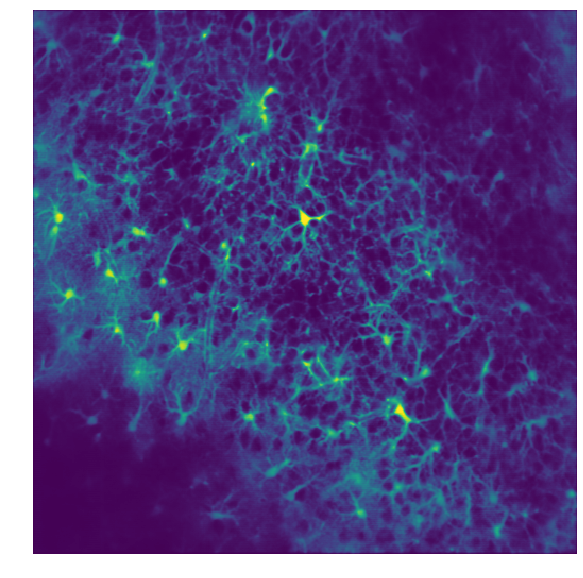

In [12]:
create_grid_plot_l(im_enh_l,1,1)

[652 579  18 175 260  14 489 357 172 321 359 452 182 380 299  56 638 446
  10  90 366 598 267 364 479]


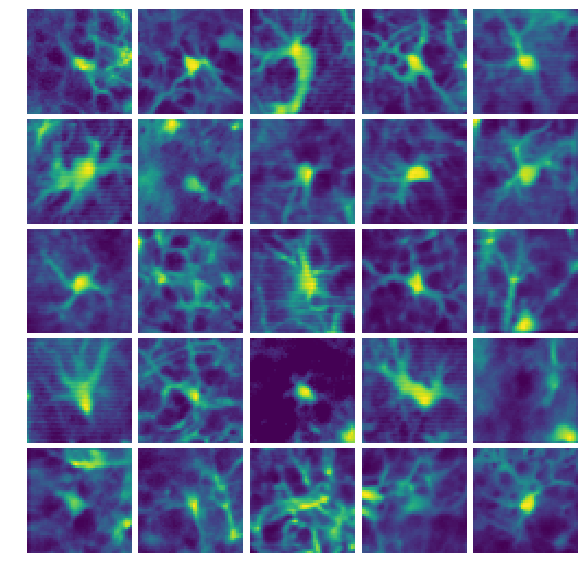

In [13]:
def create_grid_plot(items,ncol,nrow):
    np.random.seed(20)
    num = ncol*nrow
    sample = np.random.choice(len(items), num,replace=False)
    print(sample)
    plt.figure(figsize = (10,10))
    gs1 = gridspec.GridSpec(nrow, ncol)
    gs1.update(wspace=0.0, hspace=0.05) # set the spacing between axes. 

    for i in range(num):
        im = io.imread(items[sample[i]])
       # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('off')
        ax1.set_aspect('equal')
        ax1.imshow(im)
        
images_l = glob.glob(folder_single+'*.tif')
images_l.sort()
images_l_filt = [i for i in images_l if not('nf_enh' in i)]


images_l_nfilt= [i for i in images_l if 'nf_enh' in i]


create_grid_plot(images_l_nfilt,5,5)

[652 579  18 175 260  14 489 357 172 321 359 452 182 380 299  56 638 446
  10  90 366 598 267 364 479]


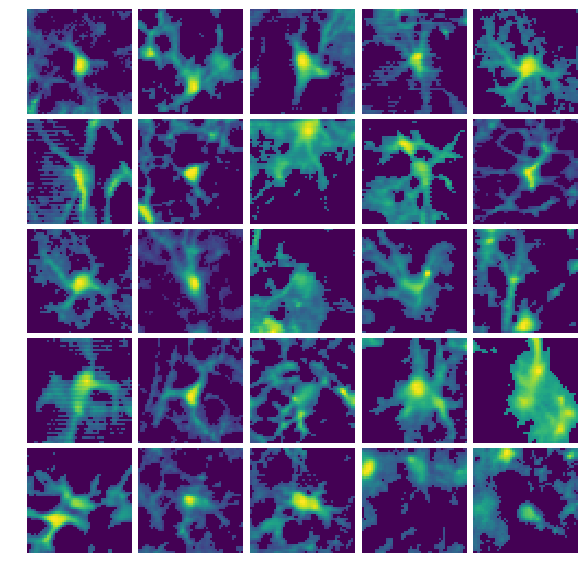

In [14]:
create_grid_plot(images_l_filt,5,5)